# Bilinear-SRGAN Project

In [ ]:
# Checking if GPU is available, it must be
!nvidia-smi

Sat Apr  6 00:46:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Extracting the dataset**

After uploading the dataset as a ZIP file to the environment, we use the following code to extract its contents into the main directory.

In [ ]:
import zipfile

# Unzip the dataset
zip_ref = zipfile.ZipFile("/content/archive.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

# **Breaking each image into 25 equal sized sections and saving into a new folder**

This code processes a dataset of high-resolution (HR) and low-resolution (LR) images for training and validation by dividing each image into 25 smaller sections. It creates separate directories for HR and LR images and saves the cropped sections with unique filenames indicating their original image and section number. This approach helps manage resource consumption during training and validation by handling smaller image sections instead of the entire image.

In [ ]:
"""
Dataset from: https://www.kaggle.com/datasets/jagan028/img-superres

Cropping the HR original 510x510 rgb images to 25 equal 102x102 rgb image
Cropping the LR original 170x170 rgb images to 25 equal 34x34 rgb image
"""

import cv2
import os

dataset_dir = "/content/AnalyticsArena_DataSet"
new_dataset_dir = "/content"

# Creating new directories
if not os.path.exists(new_dataset_dir + "hr_valid_images"):
    os.makedirs(new_dataset_dir + "/hr_valid_images")
    os.makedirs(new_dataset_dir + "/hr_train_images")
    os.makedirs(new_dataset_dir + "/lr_valid_images")
    os.makedirs(new_dataset_dir + "/lr_train_images")

# For HR Training Images
for img in os.listdir(dataset_dir + "/highres/HighResolution_Train"):
    img_array = cv2.imread(dataset_dir + "/highres/HighResolution_Train/" + img)

    # Crop the original 510x510 RGB image into 25 102x102 RGB sections
    for row in range(5):
        for col in range(5):
            y_start = row * 102
            y_end = y_start + 102
            x_start = col * 102
            x_end = x_start + 102

            img_section = img_array[y_start:y_end, x_start:x_end]
            section_index = row * 5 + col

            # Save image to folder
            section_filename = f"{img[:-4]}_{section_index}.jpg"
            cv2.imwrite(os.path.join(new_dataset_dir, "hr_train_images", section_filename), img_section)

# For HR Validation Images
for img in os.listdir(dataset_dir + "/highresvalid/HighResolution_Valid"):
    img_array = cv2.imread(dataset_dir + "/highresvalid/HighResolution_Valid/" + img)

    # Crop the original 510x510 RGB image into 25 102x102 RGB sections
    for row in range(5):
        for col in range(5):
            y_start = row * 102
            y_end = y_start + 102
            x_start = col * 102
            x_end = x_start + 102

            img_section = img_array[y_start:y_end, x_start:x_end]
            section_index = row * 5 + col

            # Save image to folder
            section_filename = f"{img[:-4]}_{section_index}.jpg"
            cv2.imwrite(os.path.join(new_dataset_dir, "hr_valid_images", section_filename), img_section)

# For LR Training Images
for img in os.listdir(dataset_dir + "/lowres/LowReolution_3x_Train"):
    img_array = cv2.imread(dataset_dir + "/lowres/LowReolution_3x_Train/" + img)

    # Crop the original 170x170 RGB image into 25 34x34 RGB sections
    for row in range(5):
        for col in range(5):
            y_start = row * 34
            y_end = y_start + 34
            x_start = col * 34
            x_end = x_start + 34

            img_section = img_array[y_start:y_end, x_start:x_end]
            section_index = row * 5 + col

            # Save image to folder
            section_filename = f"{img[:-4]}_{section_index}.jpg"
            cv2.imwrite(os.path.join(new_dataset_dir, "lr_train_images", section_filename), img_section)

# For LR Validation Images
for img in os.listdir(dataset_dir + "/lowresvalid/LowResolution_3x_Valid"):
    img_array = cv2.imread(dataset_dir + "/lowresvalid/LowResolution_3x_Valid/" + img)

    # Crop the original 170x170 RGB image into 25 34x34 RGB sections
    for row in range(5):
        for col in range(5):
            y_start = row * 34
            y_end = y_start + 34
            x_start = col * 34
            x_end = x_start + 34

            img_section = img_array[y_start:y_end, x_start:x_end]
            section_index = row * 5 + col

            # Save image to folder
            section_filename = f"{img[:-4]}_{section_index}.jpg"
            cv2.imwrite(os.path.join(new_dataset_dir, "lr_valid_images", section_filename), img_section)

# **Defining the model**

This code defines the architecture for a Super-Resolution Generative Adversarial Network (SRGAN) model, consisting of a generator, a discriminator, and a feature extractor based on VGG19. The generator uses residual blocks and upsampling blocks to enhance low-resolution images to high-resolution, while the discriminator distinguishes between real high-resolution images and generated ones. The VGG19 model is used to extract features from the generated images for calculating content loss. The combined model is used to train the generator and discriminator together.

In [ ]:
# Single Image Super-Resolution Using SRGAN Model
#All images resized to 102x102 to represent HR and 34x34 to represent LR.

import os

########################################################################
## Must be before importing libraries
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#import tensorflow as tf
#tf.get_logger().setLevel('ERROR')
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#########################################################################

import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from keras.layers import Conv2DTranspose, Cropping2D, Lambda
from tqdm import tqdm
import csv
from keras.applications import VGG19


#Define blocks to build the generator
def res_block(ip):
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

def upscale_block(ip):
    up_model = Conv2DTranspose(256, (3, 3), strides=(3, 3), padding='same')(ip)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    #layers = upscale_block(layers)
    layers = upscale_block(layers)

    sr_output = Conv2D(3, (9,9), padding="same")(layers)

    # Apply bilinear interpolation to the low-resolution input
    img_lr_resized = UpSampling2D(size=(3, 3), interpolation='bilinear')(gen_ip)
    # Combine the SR and bicubic images with weights 0.75 and 0.25, respectively
    combined_output = add([0.75*sr_output, 0.25*img_lr_resized])

    return Model(inputs=gen_ip, outputs=combined_output)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

#Descriminartor
def create_disc(disc_ip):
    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

#VGG19
def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)

    # Add an upsampling layer to increase the size from 25x25 to 50x50
    upsampled = UpSampling2D(size=(2, 2))(vgg.layers[10].output)

    # Add a cropping layer to reduce the size from 50x50 to 34x34
    cropped = Cropping2D(cropping=((8, 8), (8, 8)))(upsampled)

    return Model(inputs=vgg.inputs, outputs=cropped)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)

    gen_features = vgg(gen_img)

    disc_model.trainable = False
    validity = disc_model(gen_img)

    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# **Loading a few images to create the model**

In this code, we're loading a small subset of high-resolution (HR) and low-resolution (LR) training images from their respective directories to create the model. Later, during the training process, images will be loaded in batches. The images are converted from BGR to RGB format and stored in arrays. We then randomly select an image and plot both the LR and HR versions side by side to visually inspect them and ensure there are no errors in the preprocessing steps. Finally, the pixel values of the images are scaled to the range [0, 1] for better model performance.

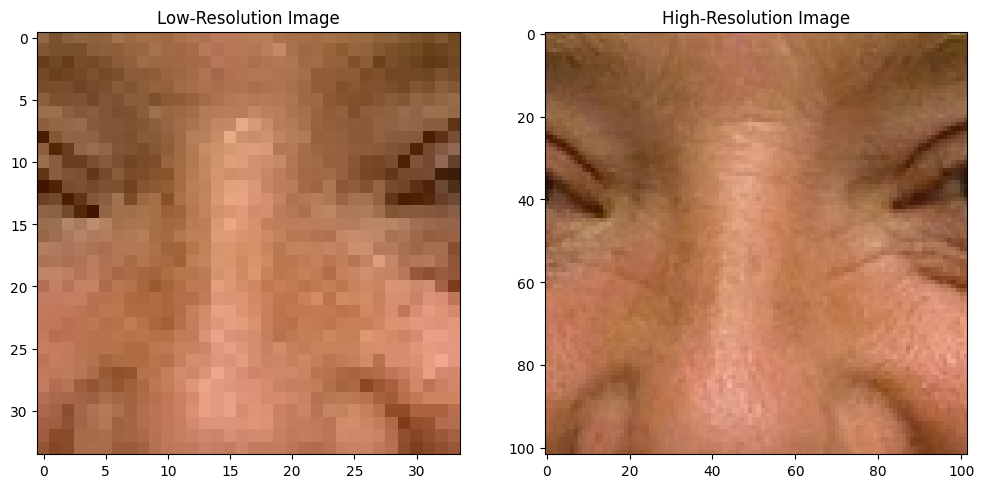

Img0_12.jpg


In [ ]:
# Loading HR Train images
img_list = sorted(os.listdir("/content/hr_train_images")) [0:5]
hr_train = []
for img in img_list:
    img_hr = cv2.imread("/content/hr_train_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_train.append(img_hr)

# Loading LR Train images
img_list = sorted(os.listdir("/content/lr_train_images")) [0:5]
lr_train = []
for img in img_list:
    img_lr = cv2.imread("/content/lr_train_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_train.append(img_lr)
img_list = 0


hr_train = np.array(hr_train)
lr_train = np.array(lr_train)

#Sanity check, view few mages
import random
image_number = random.randint(0, len(hr_train)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_train[image_number], (34, 34, 3)))
plt.title(f'Low-Resolution Image')
plt.subplot(122)
plt.imshow(np.reshape(hr_train[image_number], (102, 102, 3)))
plt.title(f'High-Resolution Image')
plt.show()
print(sorted(os.listdir("/content/hr_train_images"))[image_number])

#Scale values
hr_train = hr_train / 255.
lr_train = lr_train / 255.

# **Creating the model**

In this code, the shapes of high-resolution (HR) and low-resolution (LR) images are defined based on the training data dimensions, and these shapes are used to create input layers for the generator and discriminator models. The generator model is constructed with a specified number of residual blocks, and the discriminator model is compiled with binary cross-entropy loss and accuracy metrics. Additionally, a VGG19 model is built for feature extraction, and a combined Bilinear_SRGAN model is created by connecting the generator, discriminator, and VGG models, compiled with a combination of binary cross-entropy and mean squared error losses. This implementation is based on the original SRGAN model, but it has been tweaked for 3x image upscaling.

In [ ]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((102,102,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

print(gan_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 34, 34, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 34, 34, 64)           15616     ['input_1[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 34, 34, 64)           64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 34, 34, 64)           36928     ['p_re_lu[0][0]']             
                                                                                              

# **Training the model**

This code trains a generative adversarial network (GAN) for image super-resolution, processing the images in sections due to limited resources. Each section consists of 3500 images, and the training is done in batches. After each section, the losses are calculated and saved to a CSV file. At the end of each epoch, the Bilinear-SRGAN (GAN) model, along with the generator and discriminator, is saved to the specified directory. The training is designed to handle a large dataset of 87,500 images by dividing it into manageable sections, ensuring efficient use of memory and computational resources.

In [ ]:
total_images = 87500
section_size = 3500
sections = total_images // section_size

epochs = 1  # Total number of epochs to train

# Create a list of images for LR and HR in batches from which a batch of images would be fetched during training.
batch_size = 1
train_lr_batches = []
train_hr_batches = []

# Save results to a CSV file for automation
csv_file_path = '/content/training_results.csv'
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Section", "GAN Loss", "Discriminator Loss Generated Fake Images", "Discriminator Loss Real Images", "Adversarial Loss", "Content (VGG) Loss"])

for e in range(epochs):
    print(f"Epoch {e + 1}/{epochs}")

    # Load and sort HR and LR image paths
    hr_img_paths = sorted(os.listdir("/content/hr_train_images"))
    lr_img_paths = sorted(os.listdir("/content/lr_train_images"))

    # Pair up HR and LR image paths
    img_pairs = list(zip(hr_img_paths, lr_img_paths))

    # Shuffle the pairs
    random.shuffle(img_pairs)

    # Unzip the shuffled pairs back into separate lists
    hr_img_paths, lr_img_paths = zip(*img_pairs)

    # Now you can use hr_img_paths and lr_img_paths in your sections loop
    for section in range(sections):
        n_init = section * section_size
        n_final = n_init + section_size

        # Load HR and LR images for the current section
        hr_train = [cv2.cvtColor(cv2.imread(f"/content/hr_train_images/{hr_path}"), cv2.COLOR_BGR2RGB) for hr_path in hr_img_paths[n_init:n_final]]
        lr_train = [cv2.cvtColor(cv2.imread(f"/content/lr_train_images/{lr_path}"), cv2.COLOR_BGR2RGB) for lr_path in lr_img_paths[n_init:n_final]]

        # Convert to numpy arrays and scale
        hr_train = np.array(hr_train) / 255.
        lr_train = np.array(lr_train) / 255.

        # Create batches
        train_lr_batches = [lr_train[i:i + batch_size] for i in range(0, len(lr_train), batch_size)]
        train_hr_batches = [hr_train[i:i + batch_size] for i in range(0, len(hr_train), batch_size)]

        fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
        real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.

        # Create empty lists to populate gen and disc losses.
        gan_losses = []
        d_losses = []
        adv_losses = []
        cont_losses = []

        # Enumerate training over batches.
        for b in tqdm(range(len(train_hr_batches))):
            lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
            hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training

            fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images

            # First, train the discriminator on fake and real HR images.
            discriminator.trainable = True
            d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label) # loss associated with the discriminator's ability to correctly identify generated (fake) images
            d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)  # loss associated with the discriminator's ability to correctly identify real images

            # Now, train the generator by fixing discriminator as non-trainable
            discriminator.trainable = False

            # Average the discriminator loss, just for reporting purposes.
            d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

            # Extract VGG features, to be used towards calculating loss
            image_features = vgg.predict(hr_imgs)

            # Train the generator via GAN.
            # Remember that we have 2 losses, adversarial loss and content (VGG) loss
            gan_loss, adv_loss, cont_loss = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

            # Save losses to a list so we can average and report.
            d_losses.append(d_loss)
            gan_losses.append(gan_loss)
            adv_losses.append(adv_loss)
            cont_losses.append(cont_loss)

        # Convert the list of losses to an array to make it easy to average
        gan_losses = np.array(gan_losses)
        d_losses = np.array(d_losses)
        adv_losses = np.array(adv_losses)
        cont_losses = np.array(cont_losses)

        # Calculate the average losses for generator and discriminator
        gan_loss = np.sum(gan_losses, axis=0) / len(gan_losses)
        d_loss = np.sum(d_losses, axis=0) / len(d_losses)
        adv_loss = np.sum(adv_losses, axis=0) / len(adv_losses)
        cont_loss = np.sum(cont_losses, axis=0) / len(cont_losses)

        # Write the results to the CSV file and flush
        with open(csv_file_path, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([e, section, gan_loss, d_loss[0], d_loss[1], adv_loss, cont_loss])
            file.flush()

    # Save the GAN model after each epoch
    gan_model.save("/content/gan_e" + str(e) + ".h5")
    # Save the generator and discriminator
    generator.save("/content/gen_e" + str(e) + ".h5")
    discriminator.trainable = True  # Ensure the discriminator is in a trainable state before saving
    discriminator.save("/content/disc_e" + str(e) + ".h5")
    discriminator.trainable = False  # Set it back to non-trainable if needed for further training

# **Loading previous model version and training**

This code demonstrates how to load previously trained models for a generative adversarial network (GAN), generator, and discriminator from saved files. Once loaded, the GAN model is compiled with the loaded generator and discriminator, allowing for continued training from the saved state by returning to the "Training the model" section.

In [ ]:
import zipfile

# Unzip the pretrained model
zip_ref = zipfile.ZipFile("/content/TrainedModels.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

In [ ]:
import os

########################################################################
## Must be before importing libraries
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#import tensorflow as tf
#tf.get_logger().setLevel('ERROR')
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#########################################################################

import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from keras.layers import Conv2DTranspose, Cropping2D, Lambda
from tqdm import tqdm
import csv


#VGG19
from keras.applications import VGG19
def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=hr_shape)
    # Add an upsampling layer to increase the size from 25x25 to 50x50
    upsampled = UpSampling2D(size=(2, 2))(vgg.layers[10].output)
    # Add a cropping layer to reduce the size from 50x50 to 34x34
    cropped = Cropping2D(cropping=((8, 8), (8, 8)))(upsampled)
    return Model(inputs=vgg.inputs, outputs=cropped)


gan_model_path = '/content/gan.h5'
gen_model_path = '/content/gen.h5'
disc_model_path = '/content/disc.h5'


# Load the last saved models
from keras.models import load_model
gan_model = load_model(gan_model_path)
generator = load_model(gen_model_path)
discriminator = load_model(disc_model_path)
# Compile the GAN model with the loaded generator and discriminator
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")


# Now that the model is loaded, precede to the "Training the model" section

# **Testing**

Loading a few images for testing

In [ ]:
# Loading test images

n_init_valid = 0
n_final_valid = 150

# Loading HR Validation images
img_list = sorted(os.listdir("/content/hr_valid_images"))[n_init_valid:n_final_valid]
hr_test = []
for img in img_list:
    img_hr = cv2.imread("/content/hr_valid_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_test.append(img_hr)

# Loading LR Validation images
img_list = sorted(os.listdir("/content/lr_valid_images"))[n_init_valid:n_final_valid]
lr_test = []
for img in img_list:
    img_lr = cv2.imread("/content/lr_valid_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_test.append(img_lr)
img_list = 0

hr_test = np.array(hr_test)
lr_test = np.array(lr_test)

hr_test = hr_test / 255.
lr_test = lr_test / 255.

1/1 [==============================] - 2s 2s/step


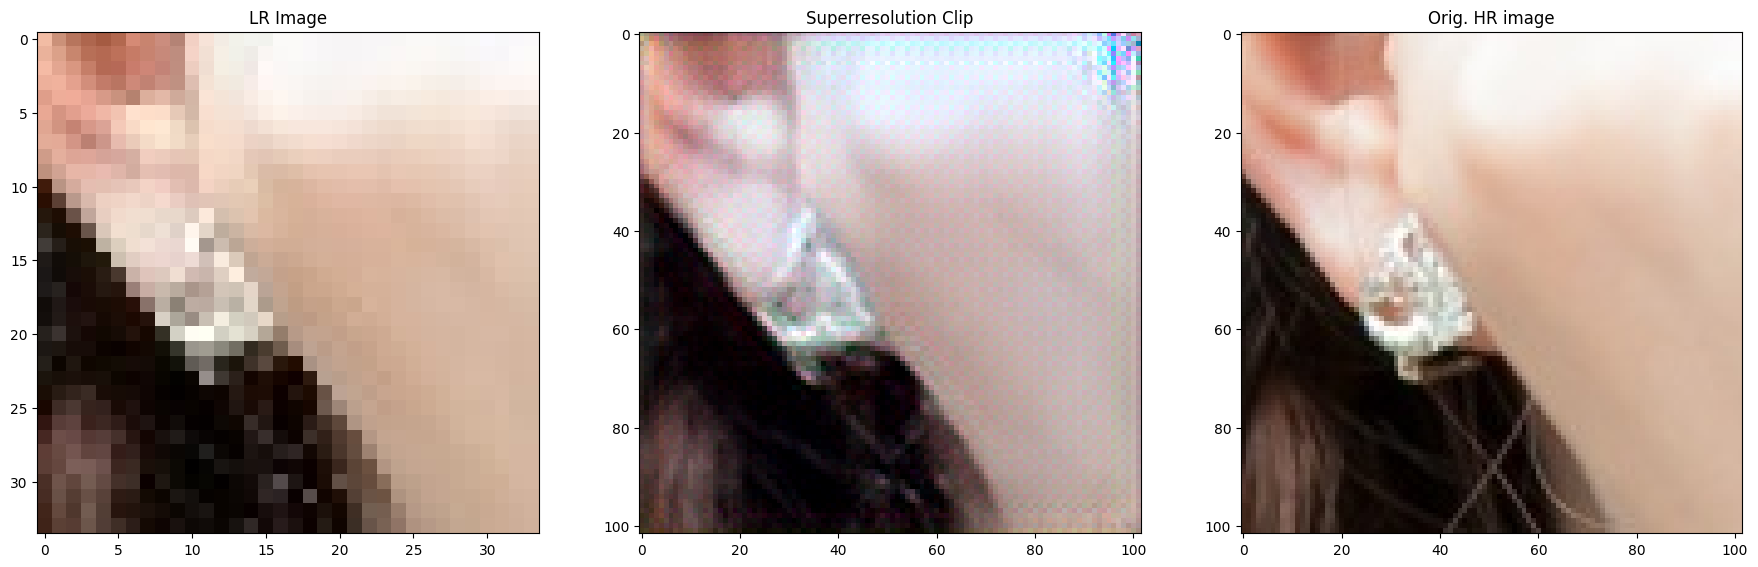

In [ ]:
from keras.models import load_model
from numpy.random import randint

#gan_model = load_model('/content/gan.h5')
generator = load_model('/content/gen.h5')
#discriminator = load_model('/content/disc.h5')


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# Clip the values to the range [0, 1]
gen_image3 = np.clip(gen_image, 0, 1)
# Convert the image to the range [0, 255] and save it
gen_image3 = (gen_image3 * 255).astype('uint8')


# plot all three images
plt.figure(figsize=(22, 8))
plt.subplot(131)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(132)
plt.title('Superresolution Clip')
plt.imshow(gen_image3[0,:,:,:])
plt.subplot(133)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

This code creates a new model that outputs both the SRGAN and bilinear outputs from a pre-trained generator model, and then uses this model to predict and visualize these outputs along with the low-resolution input and original high-resolution image. It demonstrates the process of accessing intermediate layers in a neural network model to analyze and compare the effects of different components of the model.

1/1 [==============================] - 1s 1s/step


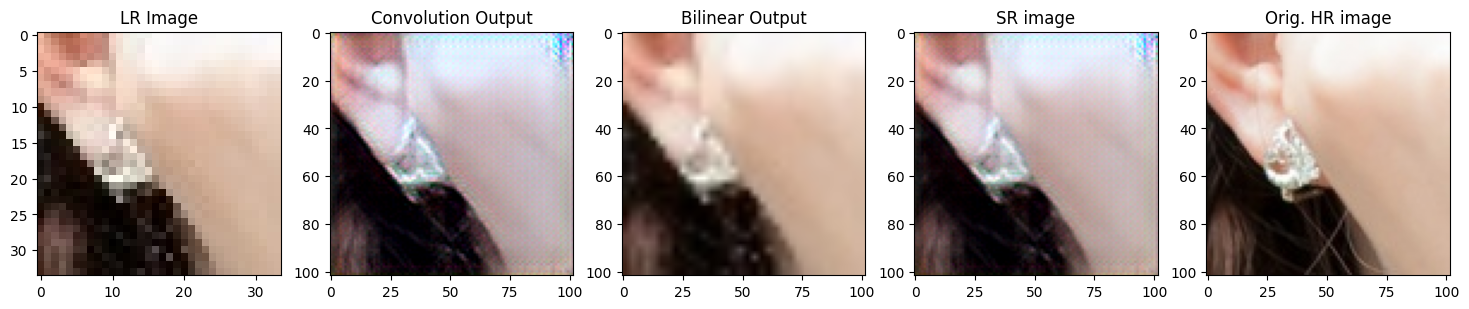

In [ ]:
from keras.models import Model

# Load the trained generator model
generator = load_model('/content/gen.h5')

# Create a new model that outputs the SRGAN output and the bilinear output
layer_name_srgan = 'conv2d_34'  # Name of the layer that provides SRGAN output
layer_name_bilinear = 'up_sampling2d'  # Name of the layer that provides bilinear output
srgan_output = generator.get_layer(layer_name_srgan).output
bilinear_output = generator.get_layer(layer_name_bilinear).output
intermediate_model = Model(inputs=generator.input, outputs=[srgan_output, bilinear_output])

# Use this new model to predict
sr_output, bilinear_output = intermediate_model.predict(src_image)

# Normalize and clip the SRGAN output
sr_output_normalized = (sr_output - np.min(sr_output)) / (np.max(sr_output) - np.min(sr_output))
sr_output_clipped = np.clip(sr_output, 0, 1)

# Normalize and clip the bilinear output
bilinear_output_normalized = (bilinear_output - np.min(bilinear_output)) / (np.max(bilinear_output) - np.min(bilinear_output))
bilinear_output_clipped = np.clip(bilinear_output, 0, 1)

# Plot all images
plt.figure(figsize=(22, 8))
plt.subplot(161)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(162)
plt.title('Convolution Output')
plt.imshow(sr_output_clipped[0,:,:,:])
plt.subplot(163)
plt.title('Bilinear Output')
plt.imshow(bilinear_output[0,:,:,:])
plt.subplot(164)
plt.title('SR image')
plt.imshow(gen_image3[0,:,:,:])
plt.subplot(165)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

# **Predict all LR Validation images**

This code predicts super-resolution images for all validation images using a pre-trained generator model, normalizes and clips the output to ensure valid image pixel values, and then saves the generated images into a specified output folder. It demonstrates the application of a trained model to generate enhanced versions of input images and the process of saving the results for further analysis.

In [ ]:
os.makedirs("/content/output_images/")

# Loading LR Validation images
img_list = sorted(os.listdir("/content/lr_valid_images"))
lr_test = []
for img in img_list:
    img_lr = cv2.imread("/content/lr_valid_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    img_lr = np.expand_dims(img_lr, axis=0)  # Add batch dimension
    img_lr = img_lr / 255.  # Normalize

    gen_image = generator.predict(img_lr)

    # Clip the values to the range [0, 1]
    gen_image = np.clip(gen_image, 0, 1)
    # Convert the image to the range [0, 255] and save it
    gen_image = (gen_image * 255).astype('uint8')

    # Save image to folder
    cv2.imwrite(os.path.join("/content/output_images/", img), cv2.cvtColor(gen_image[0], cv2.COLOR_RGB2BGR))


# **Combine images sections**

This code reconstructs high-resolution images from 25 smaller sections, each representing a part of the original image. It iterates through the sections, placing them in their correct positions to form the final 510x510 image, and then saves the reconstructed image in a specified output directory for further analysis and comparison with the original high-resolution images.

In [ ]:
import cv2
import os
import numpy as np

dataset_dir = "/content/output_images"
output_image_dir = "/content/output"
os.makedirs(output_image_dir)

for i in range(3500, 4500):
    # Initialize an empty array for the final 510x510 image
    final_image = np.zeros((510, 510, 3), dtype=np.uint8)

    # Loop through each section and place it in the correct position in the final image
    for row in range(5):
        for col in range(5):
            section_index = row * 5 + col
            section_filename = f"Img_down{i}_{section_index}.jpg"  # Replace 'image_name' with the common part of your filenames
            section_path = os.path.join(dataset_dir, section_filename)

            # Read the section image
            section_image = cv2.imread(section_path)

            # Calculate the starting and ending coordinates for this section in the final image
            y_start = row * 102
            y_end = y_start + 102
            x_start = col * 102
            x_end = x_start + 102

            # Place the section in the correct position in the final image
            final_image[y_start:y_end, x_start:x_end] = section_image

    # Save the final concatenated image
    cv2.imwrite(os.path.join(output_image_dir, f"SR_Img_{i}.jpg"), final_image)


# **Metric performance**

Measuring PSNR, MSE, and SSIM performance for all validation images.

In [ ]:
# PSNR
import cv2
import os

hr_valid_dir = "/content/AnalyticsArena_DataSet/highresvalid/HighResolution_Valid"
sr_valid_dir = "/content/output"

hr_valid_img = sorted(os.listdir(hr_valid_dir))
sr_valid_img = sorted(os.listdir(sr_valid_dir))

total_psnr = 0
num_images = 0
highest_psnr = -np.inf
lowest_psnr = np.inf

for i in range(3500, 4500):
    img_hr = cv2.imread(os.path.join(hr_valid_dir, hr_valid_img[i - 3500]))
    img_sr = cv2.imread(os.path.join(sr_valid_dir, sr_valid_img[i - 3500]))
    psnr = cv2.PSNR(img_hr, img_sr)
    total_psnr += psnr
    num_images += 1
    highest_psnr = max(highest_psnr, psnr)
    lowest_psnr = min(lowest_psnr, psnr)

average_psnr = total_psnr / num_images
print(f"Highest PSNR: {highest_psnr}")
print(f"Lowest PSNR: {lowest_psnr}")
print(f"Average PSNR: {average_psnr}")


In [ ]:
# MSE
import cv2
import os
import numpy as np

def mse(imageA, imageB):
    # Calculate the MSE between the two images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * imageA.shape[2])
    return err

hr_valid_dir = "/content/AnalyticsArena_DataSet/highresvalid/HighResolution_Valid"
sr_valid_dir = "/content/output"

hr_valid_img = sorted(os.listdir(hr_valid_dir))
sr_valid_img = sorted(os.listdir(sr_valid_dir))

total_mse = 0
num_images = 0
highest_mse = -np.inf
lowest_mse = np.inf

for i in range(3500, 4500):
    img_hr = cv2.imread(os.path.join(hr_valid_dir, hr_valid_img[i - 3500]))
    img_sr = cv2.imread(os.path.join(sr_valid_dir, sr_valid_img[i - 3500]))
    mse_value = mse(img_hr, img_sr)
    total_mse += mse_value
    num_images += 1
    highest_mse = max(highest_mse, mse_value)
    lowest_mse = min(lowest_mse, mse_value)

average_mse = total_mse / num_images
print(f"Highest MSE: {highest_mse}")
print(f"Lowest MSE: {lowest_mse}")
print(f"Average MSE: {average_mse}")


In [ ]:
# SSIM
import cv2
from skimage import io
from skimage.metrics import structural_similarity as compare_ssim
import os

# Define directories
hr_valid_dir = "/content/AnalyticsArena_DataSet/highresvalid/HighResolution_Valid"
sr_valid_dir = "/content/output"

# Get sorted lists of image filenames
hr_valid_img = sorted(os.listdir(hr_valid_dir))
sr_valid_img = sorted(os.listdir(sr_valid_dir))

# Initialize variables to store SSIM values
total_ssim = 0
num_images = 0
highest_ssim = float('-inf')
lowest_ssim = float('inf')

# Loop through the images
for i in range(3500, 4500):
    # Load the high-resolution and super-resolution images
    img_hr = cv2.imread(os.path.join(hr_valid_dir, hr_valid_img[i - 3500]))
    img_sr = cv2.imread(os.path.join(sr_valid_dir, sr_valid_img[i - 3500]))

    # Convert images to grayscale
    img_hr_gray = cv2.cvtColor(img_hr, cv2.COLOR_BGR2GRAY)
    img_sr_gray = cv2.cvtColor(img_sr, cv2.COLOR_BGR2GRAY)

    # Compute the SSIM between the two images
    ssim_value = compare_ssim(img_hr_gray, img_sr_gray)

    # Update the total SSIM, highest SSIM, and lowest SSIM
    total_ssim += ssim_value
    highest_ssim = max(highest_ssim, ssim_value)
    lowest_ssim = min(lowest_ssim, ssim_value)

    # Increment the number of images processed
    num_images += 1

# Calculate the average SSIM
average_ssim = total_ssim / num_images

# Print the results
print("Highest SSIM:", highest_ssim)
print("Lowest SSIM:", lowest_ssim)
print("Average SSIM:", average_ssim)


# **Testing Bilinear Interpolation alone**

In this experiment, we are using a simple model consisting of only a bilinear interpolation layer to upscale low-resolution images. The model takes 34x34 RGB images as input and upscales them to 102x102 using bilinear interpolation. The upscaled images are then saved in a designated output directory for further analysis or comparison with the original high-resolution images. The steps below are the same as before.

In [ ]:
import os

########################################################################
## Must be before importing libraries
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#import tensorflow as tf
#tf.get_logger().setLevel('ERROR')
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#########################################################################

import cv2
import numpy as np
from tensorflow.keras import layers, models

# Define the input shape
input_shape = (34, 34, 3)  # 34x34 RGB image

# Create the model
bilinear_model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.UpSampling2D(size=(3, 3), interpolation='bilinear')
])

os.makedirs("/content/output_images_bilinear/")

# Loading LR Validation images
img_list = sorted(os.listdir("/content/lr_valid_images"))
for img in img_list:
    img_lr = cv2.imread("/content/lr_valid_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    img_lr = np.expand_dims(img_lr, axis=0)  # Add batch dimension
    img_lr = img_lr / 255.  # Normalize

    gen_image = bilinear_model.predict(img_lr)

    # Clip the values to the range [0, 1]
    gen_image = np.clip(gen_image, 0, 1)
    # Convert the image to the range [0, 255] and save it
    gen_image = (gen_image * 255).astype('uint8')

    # Save image to folder
    cv2.imwrite(os.path.join("/content/output_images_bilinear/", img), cv2.cvtColor(gen_image[0], cv2.COLOR_RGB2BGR))


In [ ]:
import cv2
import os
import numpy as np

dataset_dir = "/content/output_images_bilinear"
output_image_dir = "/content/output_bilinear"
os.makedirs(output_image_dir)

for i in range(3500, 4500):
    # Initialize an empty array for the final 510x510 image
    final_image = np.zeros((510, 510, 3), dtype=np.uint8)

    # Loop through each section and place it in the correct position in the final image
    for row in range(5):
        for col in range(5):
            section_index = row * 5 + col
            section_filename = f"Img_down{i}_{section_index}.jpg"  # Replace 'image_name' with the common part of your filenames
            section_path = os.path.join(dataset_dir, section_filename)

            # Read the section image
            section_image = cv2.imread(section_path)

            # Calculate the starting and ending coordinates for this section in the final image
            y_start = row * 102
            y_end = y_start + 102
            x_start = col * 102
            x_end = x_start + 102

            # Place the section in the correct position in the final image
            final_image[y_start:y_end, x_start:x_end] = section_image

    # Save the final concatenated image
    cv2.imwrite(os.path.join(output_image_dir, f"Bilinear_Img_{i}.jpg"), final_image)


In [ ]:
# PSNR
import cv2
import os

hr_valid_dir = "/content/AnalyticsArena_DataSet/highresvalid/HighResolution_Valid"
sr_valid_dir = "/content/output_bilinear"

hr_valid_img = sorted(os.listdir(hr_valid_dir))
sr_valid_img = sorted(os.listdir(sr_valid_dir))

total_psnr = 0
num_images = 0
highest_psnr = -np.inf
lowest_psnr = np.inf

for i in range(3500, 4500):
    img_hr = cv2.imread(os.path.join(hr_valid_dir, hr_valid_img[i - 3500]))
    img_sr = cv2.imread(os.path.join(sr_valid_dir, sr_valid_img[i - 3500]))
    psnr = cv2.PSNR(img_hr, img_sr)
    total_psnr += psnr
    num_images += 1
    highest_psnr = max(highest_psnr, psnr)
    lowest_psnr = min(lowest_psnr, psnr)

average_psnr = total_psnr / num_images
print(f"Highest Bilinear PSNR: {highest_psnr}")
print(f"Lowest Bilinear PSNR: {lowest_psnr}")
print(f"Average Bilinear PSNR: {average_psnr}")


In [ ]:
# MSE
import cv2
import os
import numpy as np

def mse(imageA, imageB):
    # Calculate the MSE between the two images
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * imageA.shape[2])
    return err

hr_valid_dir = "/content/AnalyticsArena_DataSet/highresvalid/HighResolution_Valid"
sr_valid_dir = "/content/output_bilinear"

hr_valid_img = sorted(os.listdir(hr_valid_dir))
sr_valid_img = sorted(os.listdir(sr_valid_dir))

total_mse = 0
num_images = 0
highest_mse = -np.inf
lowest_mse = np.inf

for i in range(3500, 4500):
    img_hr = cv2.imread(os.path.join(hr_valid_dir, hr_valid_img[i - 3500]))
    img_sr = cv2.imread(os.path.join(sr_valid_dir, sr_valid_img[i - 3500]))
    mse_value = mse(img_hr, img_sr)
    total_mse += mse_value
    num_images += 1
    highest_mse = max(highest_mse, mse_value)
    lowest_mse = min(lowest_mse, mse_value)

average_mse = total_mse / num_images
print(f"Highest Bilinear MSE: {highest_mse}")
print(f"Lowest Bilinear MSE: {lowest_mse}")
print(f"Average Bilinear MSE: {average_mse}")


In [ ]:
# SSIM
import cv2
from skimage import io
from skimage.metrics import structural_similarity as compare_ssim
import os

# Define directories
hr_valid_dir = "/content/AnalyticsArena_DataSet/highresvalid/HighResolution_Valid"
sr_valid_dir = "/content/output_bilinear"

# Get sorted lists of image filenames
hr_valid_img = sorted(os.listdir(hr_valid_dir))
sr_valid_img = sorted(os.listdir(sr_valid_dir))

# Initialize variables to store SSIM values
total_ssim = 0
num_images = 0
highest_ssim = float('-inf')
lowest_ssim = float('inf')

# Loop through the images
for i in range(3500, 4500):
    # Load the high-resolution and super-resolution images
    img_hr = cv2.imread(os.path.join(hr_valid_dir, hr_valid_img[i - 3500]))
    img_sr = cv2.imread(os.path.join(sr_valid_dir, sr_valid_img[i - 3500]))

    # Convert images to grayscale
    img_hr_gray = cv2.cvtColor(img_hr, cv2.COLOR_BGR2GRAY)
    img_sr_gray = cv2.cvtColor(img_sr, cv2.COLOR_BGR2GRAY)

    # Compute the SSIM between the two images
    ssim_value = compare_ssim(img_hr_gray, img_sr_gray)

    # Update the total SSIM, highest SSIM, and lowest SSIM
    total_ssim += ssim_value
    highest_ssim = max(highest_ssim, ssim_value)
    lowest_ssim = min(lowest_ssim, ssim_value)

    # Increment the number of images processed
    num_images += 1

# Calculate the average SSIM
average_ssim = total_ssim / num_images

# Print the results
print("Highest Bilinear SSIM:", highest_ssim)
print("Lowest Bilinear SSIM:", lowest_ssim)
print("Average Bilinear SSIM:", average_ssim)
